<a href="https://colab.research.google.com/github/langfordzd/bursts-cc-pt/blob/main/burst_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Frequency-specific patterns of neural activity, as observed in magneto/electroencephalography (M/EEG) and local field potentials (LFPs) in humans and animals, have traditionally been thought of as temporally sustained oscillations in the excitability of the underlying neural tissue. Traditional methods of analyses are however based on trial averaging which can possible obscure the termporal characteristis of the oscillatory activity. Specifically, it appears that this activity in certain frequencies is not sustained at all, rather the act of averaging is making transient 'burst' events appear to be sustained. 

And while this appears to be true, detecting and describing bursts is a challenging endevour because it involves single trial analysis. There are a few ways that researchers have considered detecting such transient events in neural recordings that we know of; placing a power-threshold (**PT**) on a time-frequnecy map, using hidden Markov models on the amplitude envelope of the signal, and looking at the raw, or lightly altered, signal in an attempt to quantify consistent oscillatory cycles. 

In this work we will focus on both the most prominent method, the **PT** method, used to detect beta bursts in a neural signal; and in developing the cycle-consistency (**CC**) method which is based of the cycle-by-cycle technique of analysis. First we simulate realistic neural data with beta bursts that have different distributions of burst characteristics and evaluate how each method classifies bursts under each.  Following this we use each method to detail the characteristics of the bursts recovered in pre-existing mouse and macaque local field potentials, and macaque ECoG; detailing the differences of burst characteristics between each method. 


# Let's load data and scripts for the monkey LFP, mouse LFP, monkey ECoG, and simulation results
We will grab the data from osf.io and the python files we need from github. The dataframes with the names of mouse, lfp (marco,pablo), and ecog are the results of both the CC and PTA method. The ones appended _trials are the actual data, appended _bs is behavior of the trial structures, and _ids is the total number of trials. We don't look at the mouse behavior so it is missing. Then there is the sim file which contains a lot of different files to help us plot the simulation. We then import the .py files we grabbed from github. These are all helpers for each of the panel plots, and for calculating statistics. 

In [1]:
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

In [2]:
#!rm /content/*
#!rm -rf burst-cc-pt

In [3]:
!git clone https://github.com/langfordzd/bursts-cc-pt.git

Cloning into 'bursts-cc-pt'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 73 (delta 34), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (73/73), done.


In [4]:
import sys
sys.path.insert(0,'/content/bursts-cc-pt')
#%cd burst-methods

In [5]:
!curl -L -J -O 'https://osf.io/r84ma/download'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   469  100   469    0     0    334      0  0:00:01  0:00:01 --:--:--   334
100 2823M  100 2823M    0     0  13.2M      0  0:03:32  0:03:32 --:--:-- 13.3M
curl: Saved to filename 'results.zip'


In [6]:
!unzip results.zip

Archive:  results.zip
  inflating: ecog_com.json           
  inflating: ecog_objs.pkl           
  inflating: lfp_com.json            
  inflating: lfp_objs.pkl            
  inflating: mouse_com.json          
  inflating: mouse_objs.pkl          
  inflating: sim.pkl                 


In [7]:
import pandas as pd
import json
with open("mouse_com.json", "r") as fp:  
    mouse = pd.read_json(json.load(fp)) 
with open("lfp_com.json", "rb") as fp:   
    lfp = pd.read_json(json.load(fp))
    lfp['loc'] = lfp['loc']+lfp['chan'].astype(str)
    lfp['monkey'] = lfp['loc'].astype(str).str[0]
    marco = lfp[lfp['monkey']=='M']
    pablo = lfp[lfp['monkey']=='P']
with open("ecog_com.json", "rb") as fp:   
    ecog = pd.read_json(json.load(fp))     

In [8]:
import pickle
with open("ecog_objs.pkl", "rb") as fp:  
    ecog_trials, ecog_bs, ecog_ids, _, _, _ = pickle.load(fp)
with open("lfp_objs.pkl", "rb") as fp:  
    lfp_trials, lfp_bs, lfp_ids, _, _ = pickle.load(fp)
with open("sim.pkl", "rb") as fp:  
    mf_pf,mh_ph,xax,zeros,ones,twos,m_f,m_p,n_levels = pickle.load(fp)

In [9]:
#import os
#os.getcwd()
#os.chdir('/content/drive/MyDrive/bursts_notebook')
import matplotlib as mpl
import plot1, plot2, plot3, sims

#First we look at how each method recovers bursts in a simulation

We started our examination of bursts by simulating realistic burst data to get an understanding of burst detection methods in a situation where we know the ground-truth. We created twenty-five different simulated data sets for three different levels of burst probability, and a coloured-noise simulation. We then applied each method to the simulated data sets and categorized each burst as being well-recovered or not.  The distributions for both the burst amplitude and frequency can be seen in **Panel D**. The chance that any given trial in a simulation would contain a certain amount of bursts over the different burst probability levels can bee seen in **Panel C**. Finally, the averaged PSD for each set of the burst probability levels can be seen in **Panel E**.

If a recovered burst shared at least half of its time-points with a ground-truth burst, but was not more than twice as long, it was considered well-recovered. In **Panel B** we can see quite well that the CC method recovers the bursts at a high an consistent rate, while the PT method recovers at its highest about 75%. If a burst was produced by a method and it was not well-recovered it was considered a false-burst. Evaluating the method using these metrics we found that while the CC method did not produce false bursts, the PT method produced at fairly high rates at both the low and high end of burst probability spectrum, which can be seen in **Panel A**.

Given the performance on producing false bursts of the PT method we modified it to only recover a burst if the burst was over 2 cycles long at its specific frequency, this is plotted as **PTA** in both **Panel A and B** and is the method we preferred in examining the electrophysiological data.

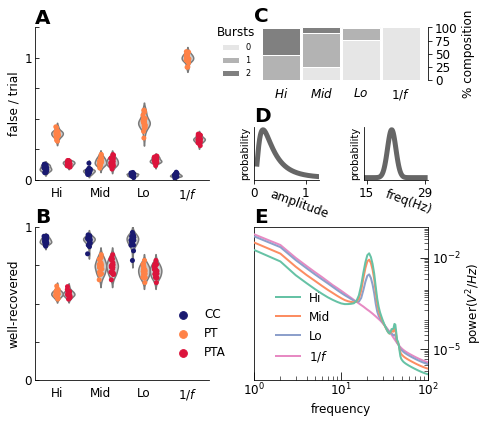

In [10]:
sims.sim_plot(mf_pf,mh_ph,xax,zeros,ones,twos,m_f,m_p,n_levels)

# How did we pick the parameters for the CC method?

We tried to chose sets of parameters that didn't give us bursts in 1/f noise as shown here: https://github.com/langfordzd/bursts-cc-pt/blob/main/parameter_picks.ipynb



# Burst Characteristics

In this plot we see duration scattered against amplitude in the 3 leftmost plots for the PTA, CC, and CO(mmon) bursts found in the mouse (**A**), LFP (**B**), and ECoG (**C**) datasets. The rightmost plots show the frequency of the detected bursts for each method and dataset.

Neurodsp etc

**Note:** We should keep in mind that for a burst to be in the common plot it has to have 50% overlap between PTA and CC bursts, and not more than twice as long. If the relax these constraints we get the same picture in any case.

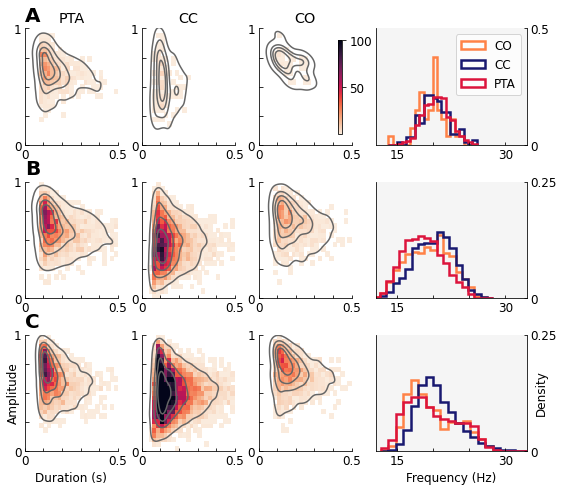

In [11]:
plot1.amp_dur(mouse,lfp,ecog)


#Duration, amplitude, frequency, and count differences abound
What we see here are paired sampled tests done on the unique bursts (i.e., the CC and PTA plots above) averaged per unit (e.g., ECoG session, or LFP channel). We have the Wilcoxon signed rank, the traditional t-test, and then a permutation t-test ([10,0.001] means 10 of 10000 permutations was more or less extreme than the observed. 


**Duration**

For all but the ECoG data the duration of the CC method was shorter than the PTA method. We should keep in mind though that each method could give different time-points for the same burst (e.g., CC method will start and stop on a cycle trough, but PTA doesn't have this constratint).

In [12]:
plot1.print_stats(mouse,'duration', 'mouse')
plot1.print_stats(marco,'duration', 'marco')
plot1.print_stats(pablo,'duration', 'pablo')
plot1.print_stats(ecog,'duration', 'ecog')


--------------------------------------------
mouse
duration
[' PT:', '0.154', '0.00733', 'vs CC:', '0.115', '0.00942']
WilcoxonResult(statistic=0.0, pvalue=0.005062032126267864)
Ttest_relResult(statistic=-11.075990483318815, pvalue=1.5190886793362269e-06)
[0, 0.0]
--------------------------------------------
marco
duration
[' PT:', '0.169', '0.0138', 'vs CC:', '0.131', '0.00913']
WilcoxonResult(statistic=0.0, pvalue=0.0006549583433856954)
Ttest_relResult(statistic=-12.869468574372075, pvalue=3.791736800620041e-09)
[0, 0.0]
--------------------------------------------
pablo
duration
[' PT:', '0.166', '0.0408', 'vs CC:', '0.144', '0.0111']
WilcoxonResult(statistic=17.0, pvalue=0.004853230851379527)
Ttest_relResult(statistic=-2.138097111655274, pvalue=0.0482849040276492)
[39, 0.0039]
--------------------------------------------
ecog
duration
[' PT:', '0.152', '0.00885', 'vs CC:', '0.159', '0.00556']
WilcoxonResult(statistic=51.0, pvalue=0.0026987267523070364)
Ttest_relResult(statistic=3.7

0

**Amplitude**

For each dataset we analyzed we see that the CC method gives us lower amplitude bursts, as well as higher amplitude bursts.

In [13]:
plot1.print_stats(mouse,'amp', 'mouse')
plot1.print_stats(marco,'amp', 'marco')
plot1.print_stats(pablo,'amp', 'pablo')
plot1.print_stats(ecog,'amp', 'ecog')

--------------------------------------------
mouse
amp
[' PT:', '0.638', '0.0151', 'vs CC:', '0.541', '0.0673']
WilcoxonResult(statistic=0.0, pvalue=0.005062032126267864)
Ttest_relResult(statistic=-4.478925362665019, pvalue=0.0015347960898162785)
[0, 0.0]
--------------------------------------------
marco
amp
[' PT:', '0.612', '0.0293', 'vs CC:', '0.449', '0.0204']
WilcoxonResult(statistic=0.0, pvalue=0.0006549583433856954)
Ttest_relResult(statistic=-17.528653824689588, pvalue=6.37577297219534e-11)
[0, 0.0]
--------------------------------------------
pablo
amp
[' PT:', '0.629', '0.0499', 'vs CC:', '0.491', '0.0301']
WilcoxonResult(statistic=2.0, pvalue=0.0004207907816778689)
Ttest_relResult(statistic=-9.504481327015064, pvalue=5.544583235377979e-08)
[0, 0.0]
--------------------------------------------
ecog
amp
[' PT:', '0.645', '0.0208', 'vs CC:', '0.511', '0.0135']
WilcoxonResult(statistic=0.0, pvalue=1.2290322210248409e-05)
Ttest_relResult(statistic=-31.98758478427699, pvalue=3.420

0

**Frequency and Count**

Interestingly the frequency in the PTA method is lower, in both the LFP and ECoG data.

Possibly the most striking difference is in the count of bursts with the CC method giving 2-4 times the amount of bursts (with the exception of the mouse data, in which the CC method didn't find many bursts). 

In [14]:
plot1.print_stats(mouse,'freq', 'mouse')
plot1.print_stats(marco,'freq', 'marco')
plot1.print_stats(pablo,'freq', 'pablo')
plot1.print_stats(ecog,'freq', 'ecog')

--------------------------------------------
mouse
freq
[' PT:', '20.4', '0.294', 'vs CC:', '20.3', '0.439']
WilcoxonResult(statistic=14.0, pvalue=0.1688069535565081)
Ttest_relResult(statistic=-1.2451552051952472, pvalue=0.24451783064910768)
pt        774
cc        136
pt_com     43
Name: which, dtype: int64
[2481, 0.2481]
--------------------------------------------
marco
freq
[' PT:', '17.8', '0.598', 'vs CC:', '18.8', '0.51']
WilcoxonResult(statistic=0.0, pvalue=0.0006549583433856954)
Ttest_relResult(statistic=8.436743322342428, pvalue=7.336625337783631e-07)
cc        2393
pt        1669
pt_com     502
Name: which, dtype: int64
[0, 0.0]
--------------------------------------------
pablo
freq
[' PT:', '20.0', '1.07', 'vs CC:', '20.7', '1.27']
WilcoxonResult(statistic=14.0, pvalue=0.003090081924360667)
Ttest_relResult(statistic=4.207135288345546, pvalue=0.000668448201739778)
cc        2777
pt        1065
pt_com     556
Name: which, dtype: int64
[23, 0.0023]
---------------------------

0

# What is the difference in the waveforms?

Next we took all of the bursts and for each one found the most extreme points. We then aligned all the bursts at these points. Given the constraints on the amount of data in the mouse (**A**) and LFP (**B**) we simply averaged over all bursts, ignoring session or recording location. The ECoG (**C**) data was different however in that we had 400 trials * 25 session, so we first averaged over the trials per session and then plotted the averaged waveform. The gray dashed vertical lines mark the time of 1 cycle.

What we see is that for the mouse there is not really enough CC bursts to make a judgment, but the PTA method definitely doesn't show much apparent rhythmicity. In the LFP we see that the gray lines meet a peak multiple times in the CC method, and only a few times in the PTA. In the ECoG data we see many clear meeting between the averaged data peaks and the cycle markers, and in the PTA method there are again only a few.

**Note:** You can also align by the minimum phase and plot it if you set 'phase = True'.

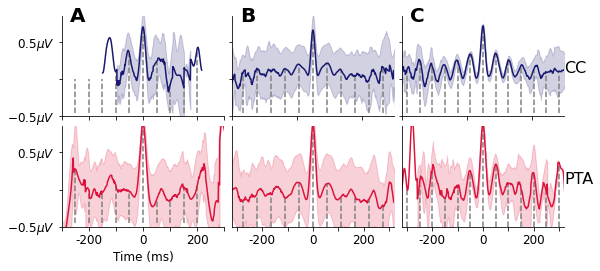

In [15]:
mouse_frx = [19,21]
lfp_frx = [16,20]
ecog_frx  = [19,21]
phase = False
mouse_f = mouse.loc[(mouse['freq'] >= mouse_frx[0]) & (mouse['freq'] <= mouse_frx[1])]
cc_mouse, pt_mouse = plot2.find_burst_data(mouse_f,phase)
lfp_f = lfp.loc[(lfp['freq'] >= lfp_frx[0]) & (lfp['freq'] <= lfp_frx[1])]
cc_lfp, pt_lfp = plot2.find_burst_data(lfp_f,phase)
ecog_f = ecog.loc[(ecog['freq'] >= ecog_frx[0]) & (ecog['freq'] <= ecog_frx[1])]
cc_ecog, pt_ecog = plot2.find_burst_data2(ecog_f,phase)

ylims = [-0.45,0.85]
dash = 'gray'
plot2.brp(
        cc_mouse,pt_mouse,mouse_frx,
        cc_lfp,pt_lfp,lfp_frx,
        cc_ecog,pt_ecog,ecog_frx,
        ylims, dash)

# What can we say about behavior?

Given that the bursts we find seem to be found in unique locations we wondered if they might be distributed differently across the trial structure. Below in **A** we first calculated for each trial the number of bursts for each method, we then split this calculation by **S**earch and **R**epetition trials in the leftmost panel. In the middle we calculated for each recording location the ratio of Search to Repetition we observed in the behavioral data and plotted this against the same ratio but calculated with the bursts. If the burst data was in an equal proportion as seen in the behavioral it would lie on the straight line.  We went ahead and tested this with a 1-sided paired permutation test and found that the CC burst ratio was greater than what was found in the behavioral data, and the PT method burst ratio was less. This means that CC bursts are more likely to be found in the search epoch, and PT burst more likely in the repetition epoch. In **B** we find the same exact pattern in the ECoG data. 

**C** are violinplots of the duration, amplitude, and frequency split by both the method, and the Search or Repetition behavior for monkey Pablo, Marco, and the ECoG data. While it is quite clear, just like as before, that the different methods find very different bursts, the picture of how these characteristics play out with behavior is not nearly as clear. 

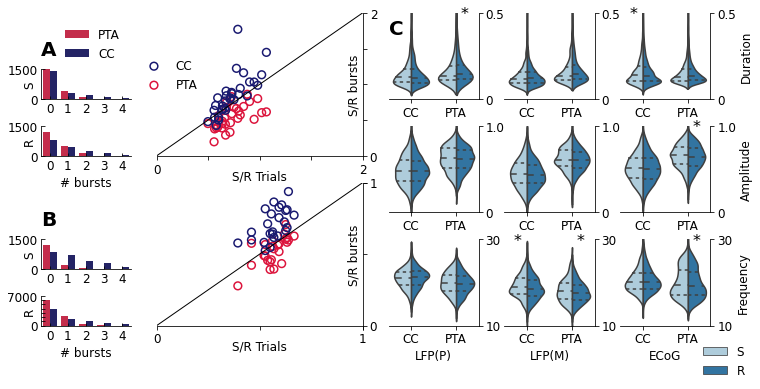

In [16]:
pt_lfp_b, pt_lfp_c      = plot3.behav(lfp,lfp_bs,lfp_trials,'pt', lfp_ids)
cc_lfp_b, cc_lfp_c      = plot3.behav(lfp,lfp_bs,lfp_trials,'cc', lfp_ids)
pt_ecog_b, pt_ecog_c    = plot3.behav(ecog,ecog_bs,ecog_trials,'pt',ecog_ids)
cc_ecog_b, cc_ecog_c    = plot3.behav(ecog,ecog_bs,ecog_trials,'cc',ecog_ids)

vio_col = 'Paired'
plot3.plot_beh(pt_lfp_b,pt_lfp_c,cc_lfp_b,cc_lfp_c,pt_ecog_b,pt_ecog_c,cc_ecog_b,cc_ecog_c,ecog,marco,pablo,vio_col,False)

In [17]:
count_lfp = pd.concat([pt_lfp_c,cc_lfp_c])
count_ecog = pd.concat([pt_ecog_c,cc_ecog_c])
behav_lfp = pd.concat([pt_lfp_b,cc_lfp_b])
behav_lfp['monkey'] = behav_lfp['loc'].astype(str).str[0]
behav_ecog = pd.concat([pt_ecog_b,cc_ecog_b])
behav_marco = behav_lfp[(behav_lfp.monkey=='M')]
behav_pablo = behav_lfp[(behav_lfp.monkey=='P')]

This next block of code will take the ratios of search to repetition trials that were seen in the trial structure for each unit (LFP electrode or ECoG session) and test it against the ratio of bursts seen in the search to repetition trials. We test it in two ways, one is a paired samples permutation test, which is what we saw earlier as well. The other way to think of it is to 

In [18]:
plot3.perm_binom_test(behav_marco,'marco','pt')
plot3.perm_binom_test(behav_marco,'marco','cc')
plot3.perm_binom_test(behav_pablo,'pablo','pt')
plot3.perm_binom_test(behav_pablo,'pablo','cc')
plot3.perm_binom_test(behav_ecog,'ecog','pt')
plot3.perm_binom_test(behav_ecog,'ecog','cc')

-------------------------------------------
Analysis of marco pt
Permutation:
2 of 10000 more extreme than observed p=  0.0002
Binomial:
14 out of 15 less than trial ratio
p=  0.0004882812499999999
-------------------------------------------

-------------------------------------------
Analysis of marco cc
Permutation:
40 of 10000 more extreme than observed p=  0.004
Binomial:
11 out of 15 greater than trial ratio
p=  0.059234619140624986
-------------------------------------------

-------------------------------------------
Analysis of pablo pt
Permutation:
4 of 10000 more extreme than observed p=  0.0004
Binomial:
15 out of 17 less than trial ratio
p=  0.0011749267578125
-------------------------------------------

-------------------------------------------
Analysis of pablo cc
Permutation:
44 of 10000 more extreme than observed p=  0.0044
Binomial:
14 out of 17 greater than trial ratio
p=  0.006362915039062502
-------------------------------------------

--------------------------

In [19]:
plot3.perm_freq_amp_dur(marco,'marco','pt','duration')
plot3.perm_freq_amp_dur(marco,'marco','pt','amp')
plot3.perm_freq_amp_dur(marco,'marco','pt','freq')
plot3.perm_freq_amp_dur(marco,'marco','cc','duration')
plot3.perm_freq_amp_dur(marco,'marco','cc','amp')
plot3.perm_freq_amp_dur(marco,'marco','cc','freq')

--------------------------------------------
Analysis of marco duration for pt
search: 0.162 ( 0.0138 ) repeat ( 0.171 ) 0.0167
915 of 10000 more extreme than observed p=  0.0915
Cohen's d=  -0.5746475861144967
--------------------------------------------

--------------------------------------------
Analysis of marco amp for pt
search: 0.623 ( 0.0353 ) repeat ( 0.608 ) 0.0283
569 of 10000 more extreme than observed p=  0.0569
Cohen's d=  0.4710677091855433
--------------------------------------------

--------------------------------------------
Analysis of marco freq for pt
search: 18.1 ( 0.823 ) repeat ( 17.7 ) 0.542
111 of 10000 more extreme than observed p=  0.0111
Cohen's d=  0.6028205025247916
--------------------------------------------

--------------------------------------------
Analysis of marco duration for cc
search: 0.132 ( 0.00938 ) repeat ( 0.13 ) 0.0101
5932 of 10000 more extreme than observed p=  0.5932
Cohen's d=  0.13497969558332448
--------------------------------

In [20]:
plot3.perm_freq_amp_dur(pablo,'pablo','pt','duration')
plot3.perm_freq_amp_dur(pablo,'pablo','pt','amp')
plot3.perm_freq_amp_dur(pablo,'pablo','pt','freq')
plot3.perm_freq_amp_dur(pablo,'pablo','cc','duration')
plot3.perm_freq_amp_dur(pablo,'pablo','cc','amp')
plot3.perm_freq_amp_dur(pablo,'pablo','cc','freq')

--------------------------------------------
Analysis of pablo duration for pt
search: 0.158 ( 0.0381 ) repeat ( 0.17 ) 0.0416
282 of 10000 more extreme than observed p=  0.0282
Cohen's d=  -0.2849296452696725
--------------------------------------------

--------------------------------------------
Analysis of pablo amp for pt
search: 0.641 ( 0.0575 ) repeat ( 0.624 ) 0.0476
771 of 10000 more extreme than observed p=  0.0771
Cohen's d=  0.2961171128255816
--------------------------------------------

--------------------------------------------
Analysis of pablo freq for pt
search: 20.2 ( 1.13 ) repeat ( 19.9 ) 1.06
716 of 10000 more extreme than observed p=  0.0716
Cohen's d=  0.28227728325651213
--------------------------------------------

--------------------------------------------
Analysis of pablo duration for cc
search: 0.142 ( 0.0111 ) repeat ( 0.145 ) 0.0126
2024 of 10000 more extreme than observed p=  0.2024
Cohen's d=  -0.23829333294151503
---------------------------------

In [21]:
plot3.perm_freq_amp_dur(ecog,'ecog','pt','duration')
plot3.perm_freq_amp_dur(ecog,'ecog','pt','amp')
plot3.perm_freq_amp_dur(ecog,'ecog','pt','freq')
plot3.perm_freq_amp_dur(ecog,'ecog','cc','duration')
plot3.perm_freq_amp_dur(ecog,'ecog','cc','amp')
plot3.perm_freq_amp_dur(ecog,'ecog','cc','freq')

--------------------------------------------
Analysis of ecog duration for pt
search: 0.151 ( 0.011 ) repeat ( 0.153 ) 0.0104
4017 of 10000 more extreme than observed p=  0.4017
Cohen's d=  -0.203255761908697
--------------------------------------------

--------------------------------------------
Analysis of ecog amp for pt
search: 0.654 ( 0.0285 ) repeat ( 0.641 ) 0.0207
101 of 10000 more extreme than observed p=  0.0101
Cohen's d=  0.5386587341290643
--------------------------------------------

--------------------------------------------
Analysis of ecog freq for pt
search: 20.1 ( 0.514 ) repeat ( 19.7 ) 0.428
23 of 10000 more extreme than observed p=  0.0023
Cohen's d=  0.7529117478890656
--------------------------------------------

--------------------------------------------
Analysis of ecog duration for cc
search: 0.162 ( 0.00516 ) repeat ( 0.157 ) 0.00684
15 of 10000 more extreme than observed p=  0.0015
Cohen's d=  0.7091227696650247
---------------------------------------

# Discussion

Could we pick up the type of bursts PTA recovers with the CC method? 

